In [1]:
# Run in terminal or command prompt
# python3 -m spacy download en
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from spacy.lang.en import English
%matplotlib inline
df = pd.read_csv('reviews_100k.csv', error_bad_lines=False, engine='python')
df = df.drop(columns=['user_id', 'review_id', 'votes.cool', 'business_id', 'votes.funny', 'stars', 'votes.useful', 'date', 'type'], axis=1)
df = df.dropna(subset=['text'])
data = df.text.values.tolist()# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]


Skipping line 27292: unexpected end of data


In [2]:
##pprint(data[:1])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
##print(data_words[:1])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  
# num chars > 3
                             # max_features=50000,             
# max number of uniq words    
                            )
                             
data_vectorized = vectorizer.fit_transform(data_lemmatized)
                             
                             # Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

['institution walk seem throwback year booth selection food speciality hoagie vote area year year order burger patty cook ingredient alternative subway road', 'customer miss machine use place steep tradition']
LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [3]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -6203136.7122004
Perplexity:  1100.2912756531923
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [4]:
# # Define Search Param
# search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# # Init the Model
# lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)
# # Do the Grid Search
# model.fit(data_vectorized)
# GridSearchCV(cv=None, error_score='raise',
#        estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#              evaluate_every=-1, learning_decay=0.7, learning_method=None,
#              learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
#              mean_change_tol=0.001, n_components=10, n_jobs=1,
#              n_topics=None, perp_tol=0.1, random_state=None,
#              topic_word_prior=None, total_samples=1000000.0, verbose=0),
#        fit_params=None, iid=True, n_jobs=1,
#        param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#        scoring=None, verbose=0)
# # Best Model
# best_lda_model = model.best_estimator_
# # Model Parameters
# print("Best Model's Params: ", model.best_params_)
# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)
# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [5]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(data_vectorized)# column names
topicnames = ['Topic' + str(i) for i in range(lda_model.n_components)]# index names
docnames = ['Doc' + str(i) for i in range(len(data))]# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames# View
df_topic_keywords.head()

# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

Topics = ["price","food","ambience","price","service", 
          "price", "service", "food", "food", "ambience", "food", "food", "none", "food", "food", "service", "service", "none", "food", "food"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,place,make,try,time,know,look,quality,year,want,think,cut,say,recommend,experience,feel,price
Topic 1,burger,ring,ingredient,number,spring,year,city,booth,deserve,roll,history,miss,meatball,favor,bone,food
Topic 2,hotel,stay,walk,room,dress,check,look,night,wedding,door,ticket,terminal,wear,drop,lady,ambience
Topic 3,store,shop,buy,selection,price,item,purchase,card,need,boyfriend,look,lot,sell,section,market,price
Topic 4,hair,bed,salon,chair,stylist,internet,haircut,job,sleep,furniture,construction,relax,client,artist,treatment,service
Topic 5,spend,mile,apartment,art,exhibit,charlotte,wood,child,combination,school,fun,floor,groupon,adult,knock,price
Topic 6,room,service,staff,work,car,care,bathroom,area,charge,need,day,class,center,experience,use,service
Topic 7,place,coffee,breakfast,spot,ice,pancake,egg,love,make,try,tea,cream,stop,come,wait,food
Topic 8,pizza,sandwich,cheese,steak,order,beef,fry,wing,eat,place,slice,crust,delivery,meat,sauce,food
Topic 9,rock,ride,play,band,theater,enjoy,layover,museum,venue,joke,carowind,stage,navigate,jazz,theme,ambience


In [6]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)# Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores# Predict the topic

#read from csv to array
import csv

mytext = []
actualTopic = []

with open('./Yelp.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            mytext.append(row[0])
            actualTopic.append(row[1])
            line_count += 1

infer_topic = []
topic = []
prob_scores = []

for i in range(len(mytext)):
    singleText = [""]
    singleText[0] = mytext[i]
    var1, var2, var3 = predict_topic(singleText)
    infer_topic.append(var1)
    topic.append(var2)
    prob_scores.append(var3)

# print(topic)
print(infer_topic)



['food', 'food', 'food', 'service', 'food', 'food', 'food', 'food', 'price', 'food', 'service', 'food', 'food', 'food', 'service', 'food', 'food', 'food', 'price', 'food', 'food', 'food', 'none']


In [7]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
df["Topic_key_word"]= df['text'].apply(apply_predict_topic)
df

,text,Topic_key_word
0,"Mr Hoagie is an institution. Walking in, it do...",food
1,Excellent food. Superb customer service. I mis...,food
2,Yes this place is a little out dated and not o...,food
3,All the food is great here. But the best thing...,food
4,We checked this place out this past Monday for...,food
...,...,...
27285,Ok I figured this would be ordinary diner food...,food
27286,Love the food and the atmosphere. I eat here a...,food
27287,"The service was nice, the front desk girls wer...",service
27288,"Horrible showers, but nice folks.",none


In [8]:
check_df = pd.DataFrame({'actual_label': actualTopic, 'prediction': infer_topic, 'review':mytext})
check_df

,actual_label,prediction,review
0,price,food,"""Great place to hang out after work: the price..."
1,price,food,"""Went here with visiting family members and wa..."
2,food,food,"""One of the few good things that I have experi..."
3,service,service,"""Alhambra location has a drive thru! But it's ..."
4,service,food,"""Open during the quarantine with social distan..."
5,food,food,"""Favorite Shawarma place in San Diego. Covid ..."
6,food,food,"""The five-star food is only enhanced by the si..."
7,service,food,"""Visited during the Covid Pandemic. You have t..."
8,service,price,"""This place is cheap and yummy. My friends' mo..."
9,food,food,"""During the pandemic, a good boba is all I nee..."


Accuracy score:  0.4782608695652174
Precision score:  0.4782608695652174


Text(91.68, 0.5, 'predicted label')

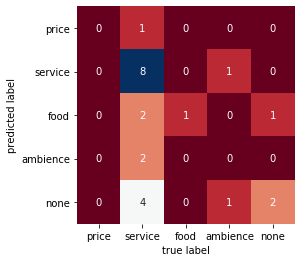

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(actualTopic, infer_topic))
print('Precision score: ', precision_score(actualTopic, infer_topic, average='micro'))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(actualTopic, infer_topic)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['price', 'service', 'food', 'ambience', 'none'], yticklabels=['price', 'service', 'food', 'ambience', 'none'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [12]:
# Predict the topic
while inp != 'quit':
    inp = input("Enter a review: ")
    print("Type 'quit' to exit ")
    arr = []
    arr.append(inp)
    infer_topic, topic, prob_scores = predict_topic(text = arr)
    print(infer_topic)

Enter a review: My food was amazing
food
Type 'quit' to exit 
Enter a review: service here was great
food
Type 'quit' to exit 
Enter a review: service
food
Type 'quit' to exit 
Enter a review: hair bed salon
service
Type 'quit' to exit 
Enter a review: quit
price
Type 'quit' to exit 
